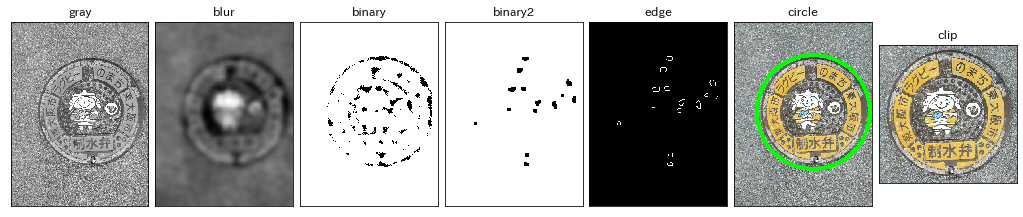

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import Debug

# 元画像が入っているフォルダへのパス
path = './src/'

# 元画像の名前一覧をゲットする
files = []
for f in glob.glob(path + '*.jpg'):
    files.append(f)
N = len(files)

# 出力画像へのパス
outputpath = './dst/'
out_num = 0

# Debug用
debug = Debug.debug(True)

for i in range(N):
    debug.initialize()

    # 画像読み込み
    gray = cv2.imread(files[i], 0)
    color = cv2.imread(files[i], 1)
    debug.draw(gray, 'gray')

    # サイズ変更
    # https://qiita.com/kenfukaya/items/dfa548309c301c7087c4
    gray = cv2.resize(gray, ((int)(gray.shape[1] * 0.1), (int)(gray.shape[0] * 0.1)))
    color = cv2.resize(color, ((int)(color.shape[1] * 0.1), (int)(color.shape[0] * 0.1)))

    # ブラー処理
    blur = cv2.GaussianBlur(gray,(19,19),0)
    blur = cv2.GaussianBlur(blur,(9,9),0)
    blur = cv2.GaussianBlur(blur,(9,9),0)
    blur = cv2.GaussianBlur(blur,(9,9),0)
    blur = cv2.GaussianBlur(blur,(9,9),0)
    debug.draw(blur, 'blur')

    # コントラスト平滑化　結局いらなかった
    # http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html
    # blur = cv2.equalizeHist(blur)
    # if Debug == True:
    #     ax = fig.add_subplot(1, 15, pos_num, xticks=[], yticks=[]) #Debug
    #     pos_num += 1 #Debug
    #     ax.set_title('contrast') #Debug
    #     ax.imshow(blur, cmap = 'gray') #Debug

    # blur = cv2.GaussianBlur(blur,(19,19),0)
    # blur = cv2.GaussianBlur(blur,(19,19),0)
    # blur = cv2.GaussianBlur(blur,(19,19),0)
    # blur = cv2.GaussianBlur(blur,(19,19),0)
    # if Debug == True:
    #     ax = fig.add_subplot(1, 15, pos_num, xticks=[], yticks=[]) #Debug
    #     pos_num += 1 #Debug
    #     ax.set_title('blur2') #Debug
    #     ax.imshow(blur, cmap = 'gray') #Debug

    # 二値化
    # https://algorithm.joho.info/programming/python/opencv-otsu-thresholding-py/
    # 方法2 （OpenCVで実装）
    # ret, blur = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU)
    # ax = fig.add_subplot(1, 15, pos_num, xticks=[], yticks=[]) #Debug
    # pos_num += 1 #Debug
    # ax.set_title('binary') #Debug
    # ax.imshow(blur, cmap = 'gray') #Debug

    # Adaptive Gaussian Thresholding
    # http://lang.sist.chukyo-u.ac.jp/classes/OpenCV/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html
    binary = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    debug.draw(binary, 'binary')

    kernel = np.ones((5,5),np.uint8)
    binary2 = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    debug.draw(binary2, 'binary2')

    counter = 0
    for x in range(binary.shape[1]):
        for y in range(binary.shape[0]):
            if binary2[y,x] == 0:
                counter += 1
    if counter > 500:
        binary = binary2


    for x in range(binary.shape[1]):
        for y in range(binary.shape[0]):
            if binary[y,x] == 0:
                blur[y,x] = 230
            else:
                blur[y,x] = 255 - blur[y,x]
            
    # エッジ検出
    # http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_canny/py_canny.html
    edges = cv2.Canny(binary,1,10, 3)
    debug.draw(edges, 'edge')


    # 縮小⇒膨張処理　（オープニング処理）
    # http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    # blur = cv2.erode(blur,kernel,iterations = 5)
    # blur = cv2.dilate(blur,kernel,iterations = 5)

    # blur = cv2.morphologyEx(blur, cv2.MORPH_OPEN, kernel)
    # if Debug == True:
    #     ax = fig.add_subplot(1, 15, pos_num, xticks=[], yticks=[]) #Debug
    #     pos_num += 1 #Debug
    #     ax.set_title('binary2') #Debug
    #     ax.imshow(blur, cmap = 'gray') #Debug


    # ヒストグラム表示
    # ヒストグラムの取得
    # img_hist_cv = cv2.calcHist([blur], [0], None, [256], [0, 256])
    # if Debug == True:
    #     plt.figure(figsize=(3, 2))
    #     plt.plot(img_hist_cv)

    

    # ハフ変換(cannyを自動的にかけてくれる)
    # http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_houghcircles/py_houghcircles.html?highlight=hough
    # https://www.pynote.info/entry/opencv-hough-circles
    maxr = 0
    xy = (0,0)
    circles = cv2.HoughCircles(blur,cv2.HOUGH_GRADIENT,3,20,param1=10,param2=100,minRadius=(int)(0.3*blur.shape[0]),maxRadius=(int)(0.5*blur.shape[1]))
    if circles is None:
        continue

    dummy = color.copy()
    circles = np.uint16(np.around(circles))
    i = circles[0][0]
    maxr = i[2]
    xy = (i[0], i[1])
    cv2.circle(dummy,(i[0],i[1]),i[2],(0,255,0),5)
    debug.draw(dummy, 'circle')

    if maxr == 0:
        continue

    xy = [(int)(xy[0]), (int)(xy[1])]
    maxr = (int)(maxr)
    max_margin = (int)(40)    
    margins = [xy[0]-maxr, xy[1]-maxr, color.shape[1]-xy[0]-maxr, color.shape[0]-xy[1]-maxr, max_margin]

    r = maxr + np.min(margins)
    left = (int)(xy[0] - r)
    right = (int)(xy[0] + r)  
    top = (int)(xy[1] - r)
    bottom = (int)(xy[1] + r)


    # クリッピング
    final_image = color[top: bottom, left:right]

    debug.draw(final_image, 'clip')
    
    cv2.imwrite(outputpath + str(out_num) + '.png', final_image)
    out_num += 1

